<a href="https://colab.research.google.com/github/aishstronomer/flare-finder/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# set globals

# do Google Colab things
try:
    from google.colab import drive

    drive.mount("/content/drive", force_remount=True)
    IN_COLAB = True
except:
    IN_COLAB = False

# install dependencies
path_to_coderepo = (
    "/content/drive/MyDrive/ML_project/code_repo/flare-finder" if IN_COLAB else "."
)
if IN_COLAB:
    !pip install -r {path_to_coderepo}/requirements.txt

# import standard libraries
from IPython.display import clear_output
import glob
import matplotlib.pyplot as plt
import pandas as pd
import sys

# import custom libraries
if f'{path_to_coderepo}/src' not in sys.path:
    sys.path.append(f'{path_to_coderepo}/src')
from goes_file_parser import GOESFileParser
from sdo_image_fetcher import SDOImageFetcher

Mounted at /content/drive


In [2]:
# save 2015 GOES events to csv

directory_path = f"{path_to_coderepo}/../../2015_events"
df = GOESFileParser.get_goes_events_df_for_interval(directory_path, "20150101", "20151231")
df.to_csv("goes_events_clean_2015.csv", index=False)

Solar images downloaded this run = 0
Total solar images available = 8550
single image_path = /content/drive/MyDrive/ML_project/code_repo/flare-finder/../../data/sdo_images/2015-08-22 04:00:11.340000+00:00.png


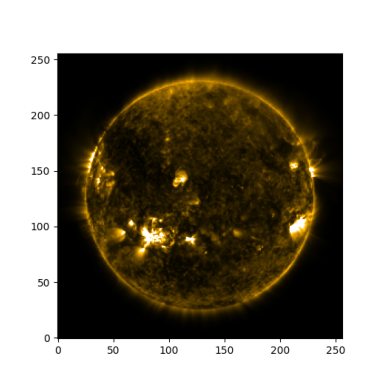

In [12]:
# fetch the solar images
# - can take long depending on connection
# - code is fault tolerant; if connection is lost, it will resume from where it left off

# common variables
s3_root_for_sdoml_year_zarr = (
    "s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2.zarr/2015/"
)
sav_folder_path = f"{path_to_coderepo}/../../data/sdo_images"

# fetch solar images for year 2015 for every hour-start
desired_times = pd.date_range(
    start="2015-01-01 00:00:00", end="2015-12-31 23:59:59", freq="60T", tz="UTC"
)
solar_imgs_fetched_paths = SDOImageFetcher.get_sdo_solar_images_from_aws(
    s3_root_for_sdoml_year_zarr,
    desired_times,
    sav_folder_path,
    tolerance=pd.Timedelta(days=1000),
    is_verbose=True,
)

# fetch solar images for Goes big flare events for year 2015
# - Big flare means M/X class flare
# - We specify a 10 min tolerance for the flare event time
goes_events_data = pd.read_csv("goes_events_clean_2015.csv")
goes_MX_events = goes_events_data[
    goes_events_data["Particulars_a"].str.lower().str.startswith(("m", "x"))
]
goes_MX_event_times = pd.to_datetime(
    goes_MX_events["max_datetime"].fillna(goes_MX_events["begin_datetime"]), utc=True
).tolist()
solar_bigflr_imgs_fetched_paths = SDOImageFetcher.get_sdo_solar_images_from_aws(
    s3_root_for_sdoml_year_zarr,
    goes_MX_event_times,
    sav_folder_path,
    tolerance=pd.Timedelta(minutes=10),
    is_verbose=True,
)

# clear console and print download stats
clear_output()
print(f"Solar images downloaded this run = {len(solar_imgs_fetched_paths) + len(solar_bigflr_imgs_fetched_paths)}")
print(f"Total solar images available = {len(glob.glob(sav_folder_path + '/*.png'))}")

# display a fetched solar image
%matplotlib inline
image_path = glob.glob(sav_folder_path + "/*.png")[0]
print(f"single image_path = {image_path}" )
plt.axis("off")
plt.imshow(plt.imread(image_path))